Box Model from SEAWAT Henry Problem Example
https://github.com/modflowpy/flopy/blob/develop/examples/Notebooks/flopy3_SEAWAT_henry_problem.ipynb

Treat left flux boundary as injection well. 
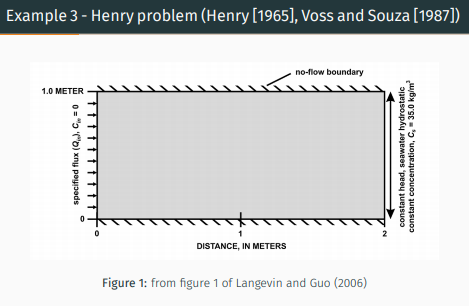
https://www2.hawaii.edu/~jonghyun/classes/S18/CEE696/files/12_flopy_seawat.pdf

In [225]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]
numpy version: 1.16.2
flopy version: 3.2.12


In [226]:
name = 'SeawatBoxModel'
workspace = 'D:/Chelsea/Projects/DelawareStream/FloPy/' + name
if not os.path.exists(workspace):
    os.makedirs(workspace)
exe_name = os.path.abspath('D:/Chelsea/Projects/DelawareStream/Script/Executables/swtv4')

In [246]:
# All inputs
len_units = 'meters'
time_units = 'days'

# Grid
Lx = 500. #total width across rows of entire model
Ly = 1000. #total width across columns
Lz = 100. #total width across depth
ztop = 1. #top elevation of layer 1
zbot = -99. #bottom elevation
nlay = 25 #number of layers
nrow = 100 #number of rows
ncol = 50 #number of columns
delr = Lx / ncol #the cell width along rows
delc = Ly / nrow #the cell width along columns
delv = (ztop - zbot) / nlay #elevation change from top to bottom of model
henry_botm = np.linspace(ztop - delv, zbot, nlay) #bottom of each layer

# Flow
hk = 864.  #m/day hydraulic conductivity
laycbd = 0 #Flags indicating whether or not a layer has a Quasi-3D confining bed below it. 0 indicates no confining bed, and not zero indicates a confining bed. 

# Time 
nper = 1 #stress periods per simulation
perlen = 1.5 #days, length of stress period
nstp =  15 #number of time steps of a stress period

# Boundaries
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #boundary variable... one value for every cell... if >0 cell is active, if =0 cell is inactive, if <0 cell has constant head. 
ibound[:, :, -1] = -1 # set the constant head cell at the boundary
strt = 0 #initial starting head... one value for every cell

# save cell fluxes to unit 53
ipakcb = 53

#Criteria for Convergence
hclose = 1.e-8 #head change criterion for convergence.

###########################################################################################################
# Transport
dmcoef = 0.57024 #m2/day  Could also try 1.62925 as another case of the Henry problem. DMCOEF is used in MT3D as the effective molecular diffusion coefficient.
prsity = 0.35 #porosity
al = 0. #longitudinal dispersivity, L
trpt = 1. #ratio of transverse to longitudinal dispersivity
sconc = 35. #starting concentration

# Advection
mixelm = 0 # integer flag for the advection solution option, = 0, the standard finite-difference method with upstream or central-in-space weighting
nprs=-5 #A flag indicating (i) the frequency of the output and (ii) whether the output frequency is specified in terms of total elapsed simulation time or the transport step number. 
ifmtcn=0 #A flag/format code indicating how the calculated concentration should be printed to the standard output text file.
chkmas=True #A logical flag indicating whether a one-line summary of mass balance information should be printed.
nprobs=10 #An integer indicating how frequently the concentration at the specified observation points should be saved. 
nprmas=10 #An integer indicating how frequently the mass budget information should be saved. 
dt0=0.001 #The user-specified initial transport step size within each time-step of the flow solution. 
trpv=1. # is the ratio of the vertical transverse dispersivity to the longitudinal dispersivity.  
iter1 = 500 #max num of inner iterations
mxiter = 1 #max num of outer iterations
isolve=1 #type of preconditioners to be used with the Lanczos/ORTHOMIN acceleration scheme: = 1, Jacobi = 2, SSOR = 3 
cclose=1e-4 #convergence criterion in terms of relative concentration; a real value between 10-4 and 10-6 is generally adequate.
 
    
# Variable Density 
iwtable=0 #flag for variable-density water-table corrections (Guo and Langevin, 2002, eq. 82). If IWTABLE = 0, the water-table correction will not be applied. If IWTABLE > 0, the water-table correction will be applied.
densemin=0 #minimum fluid density
densemax=0 #maximum fluid density
denseref=1000. #fluid density at the reference conc, temp, and press. For most simulations, DENSEREF is specified as the density of freshwater at 25 degrees C and at a reference pressure of zero.
denseslp=0.7143 #slope of the linear equation of state that relates fluid density to solute concentration
firstdt=1e-3 #length of the first transport timestep used to start the simulation if both of the following two condi- tions are met: 1. The IMT Process is active, and 2. transport timesteps are calculated as a function of the user-specified Courant number (the MT3DMS input variable, PERCEL, is greater than zero).

# Create WEL and SSM data
itype = flopy.mt3d.Mt3dSsm.itype_dict()
wel_data = {}
ssm_data = {}
wel_sp1 = []
ssm_sp1 = []
qinflow = 5.702  #m3/day
for ik in range(nrow):
    for k in range(nlay):
        wel_sp1.append([k, ik, 0, qinflow / nlay]) #layer, row, col, flux
        ssm_sp1.append([k, ik, 0, 0., itype['WEL']]) #layer, row, col, starting concentration, type of cell
        ssm_sp1.append([k, ik, ncol - 1, sconc, itype['BAS6']]) # for all other cells start with seawater conc 
        
wel_sp1.append([nlay/2,33, 40, -qinflow]) #layer, row, col, flux
wel_data[0] = wel_sp1
ssm_data[0] = ssm_sp1

In [247]:
# Create the basic MODFLOW model structure
modelname = name
swt = flopy.seawat.Seawat(modelname, exe_name=exe_name, model_ws=workspace)
print(swt.namefile)

# Add DIS package to the MODFLOW model
dis = flopy.modflow.ModflowDis(swt, nlay, nrow, ncol, nper=nper, delr=delr,
                               delc=delc, laycbd=laycbd, top=ztop,
                               botm=henry_botm, perlen=perlen, nstp=nstp)

# BAS package
bas = flopy.modflow.ModflowBas(swt, ibound, strt)

# Add LPF package to the MODFLOW model
lpf = flopy.modflow.ModflowLpf(swt, hk=hk, vka=hk, ipakcb=ipakcb)

# Add PCG Package to the MODFLOW model
pcg = flopy.modflow.ModflowPcg(swt, hclose=hclose)

# Add OC package to the MODFLOW model
oc = flopy.modflow.ModflowOc(swt, 
                             stress_period_data={(0, 0): ['save head', 'save budget']},
                             compact=True)

#Wells
wel = flopy.modflow.ModflowWel(swt, stress_period_data=wel_data, ipakcb=ipakcb)

SeawatBoxModel.nam


In [248]:
# Create the basic MT3DMS model structure
#mt = flopy.mt3d.Mt3dms(modelname, 'nam_mt3dms', mf, model_ws=workspace)
btn = flopy.mt3d.Mt3dBtn(swt, nprs=nprs, prsity=prsity, sconc=sconc, ifmtcn=ifmtcn,
                         chkmas=chkmas, nprobs=nprobs, nprmas=nprmas, dt0=dt0)
adv = flopy.mt3d.Mt3dAdv(swt, mixelm=mixelm)
dsp = flopy.mt3d.Mt3dDsp(swt, al=al, trpt=trpt, trpv=trpv, dmcoef=dmcoef)
gcg = flopy.mt3d.Mt3dGcg(swt, iter1=iter1, mxiter=mxiter, isolve=isolve, cclose=cclose)
ssm = flopy.mt3d.Mt3dSsm(swt, stress_period_data=ssm_data)

# Create the SEAWAT model structure
#mswt = flopy.seawat.Seawat(modelname, 'nam_swt', mf, mt, model_ws=workspace, exe_name='swtv4')
vdf = flopy.seawat.SeawatVdf(swt, iwtable=iwtable, densemin=densemin, densemax=densemax,
                             denseref=denseref, denseslp=denseslp, firstdt=firstdt)

In [249]:
# Write the input files
swt.write_input()

In [250]:
# Try to delete the output files, to prevent accidental use of older files
try:
    os.remove(os.path.join(workspace, 'MT3D001.UCN'))
    os.remove(os.path.join(workspace, modelname + '.hds'))
    os.remove(os.path.join(workspace, modelname + '.cbc'))
except:
    pass

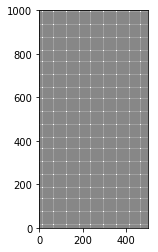

In [251]:
# Plotting
mm = flopy.plot.PlotMapView(model=swt)
plota = mm.plot_grid()

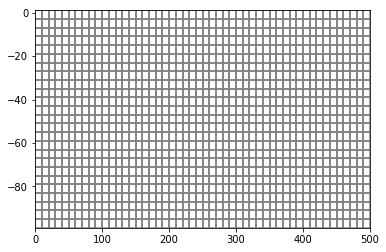

In [252]:
# Plotting
mm2 = flopy.plot.PlotCrossSection(model=swt, line={'row': 0})
plotb = mm2.plot_grid()

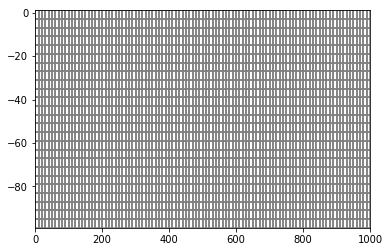

In [254]:
# Plotting
mm2 = flopy.plot.PlotCrossSection(model=swt, line={'column': 0})
plotb = mm2.plot_grid()

In [ ]:
modelmap = flopy.plot.PlotMapView(model=swt)
qm = modelmap.plot_ibound()
lc = modelmap.plot_grid()
qm = modelmap.plot_bc('CHB', alpha=0.5)
#cs = modelmap.contour_array(head, levels=levels)
#plt.clabel(cs, inline=1, fontsize=10, fmt='%1.1f')
#quiver = modelmap.plot_discharge(frf, fff, head=head)

In [ ]:
v = swt.run_model(silent=True, report=True)
for idx in range(-3, 0):
    print(v[1][idx])

In [209]:
# Post-process the results
import numpy as np
import flopy.utils.binaryfile as bf

# Load data
ucnobj = bf.UcnFile(os.path.join(workspace, 'MT3D001.UCN'), model=swt)
times = ucnobj.get_times()
concentration = ucnobj.get_data(totim=times[-1])
cbbobj = bf.CellBudgetFile(os.path.join(workspace, 'SeawatBoxModel.cbc'))
times = cbbobj.get_times()
qx = cbbobj.get_data(text='flow right face', totim=times[-1])[0]
qz = cbbobj.get_data(text='flow lower face', totim=times[-1])[0]

# Average flows to cell centers
qx_avg = np.empty(qx.shape, dtype=qx.dtype)
qx_avg[:, :, 1:] = 0.5 * (qx[:, :, 0:ncol-1] + qx[:, :, 1:ncol])
qx_avg[:, :, 0] = 0.5 * qx[:, :, 0]
qz_avg = np.empty(qz.shape, dtype=qz.dtype)
qz_avg[1:, :, :] = 0.5 * (qz[0:nlay-1, :, :] + qz[1:nlay, :, :])
qz_avg[0, :, :] = 0.5 * qz[0, :, :]

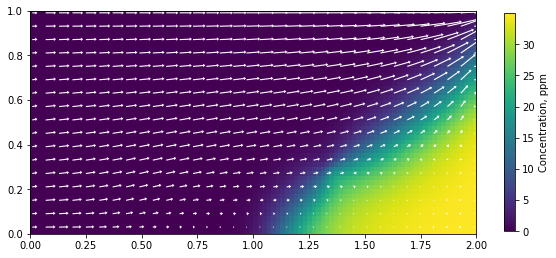

(50, 3, 100)

In [215]:
# Make the plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
concplot = ax.imshow(concentration[:, 1, :], # to move through slices
                     interpolation='nearest', extent=(0, Lx, 0, Lz))

y, x, z = dis.get_node_coordinates()
X, Z = np.meshgrid(x, z[:, 0, 0])
iskip = 3
ax.quiver(X[::iskip, ::iskip], Z[::iskip, ::iskip],
           qx_avg[::iskip, 0, ::iskip], -qz_avg[::iskip, 0, ::iskip],
           color='w', scale=5, headwidth=3, headlength=2,
           headaxislength=2, width=0.0025)
fig.colorbar(concplot, ax=ax, label = "Concentration, ppm", shrink= 0.4)
plt.savefig(os.path.join(workspace, 'SeawatBoxModel.png'))
plt.show();
concentration.shape

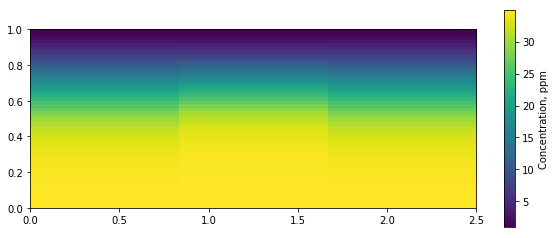

(50, 100)

In [211]:
# Make the plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
concplot = ax.imshow(concentration[:, :, 99], # to move through slices
                     interpolation='nearest', extent=(0, Ly, 0, Lz))

fig.colorbar(concplot, ax=ax, label = "Concentration, ppm", shrink= 0.4)
plt.savefig(os.path.join(workspace, 'SeawatBoxModelOceanFace.png'))
plt.show();
Z.shape

In [212]:
# Extract the heads
fname = os.path.join(workspace, 'SeawatBoxModel.hds')
headobj = bf.HeadFile(fname)
times = headobj.get_times()
head = headobj.get_data(totim=times[-1])

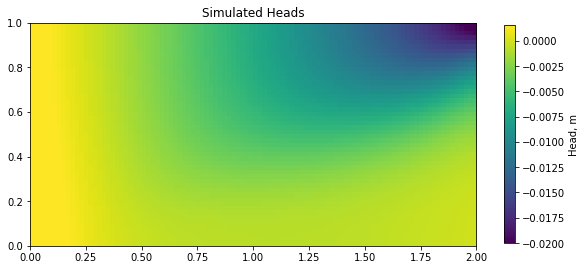

In [213]:
# Make a simple head plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
im = ax.imshow(head[:, 0, :], interpolation='nearest',
               extent=(0, Lx, 0, Lz), vmin = -0.02, vmax = 0.0015)
ax.set_title('Simulated Heads');
fig.colorbar(im, ax=ax, label = "Head, m", shrink= 0.4)

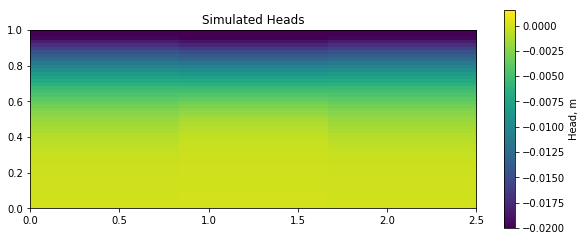

In [214]:
# Make a simple head plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
im = ax.imshow(head[:, :, 99], interpolation='nearest',
               extent=(0, Ly, 0, Lz), vmin = -0.02, vmax = 0.0015)
ax.set_title('Simulated Heads');
fig.colorbar(im, ax=ax, label = "Head, m", shrink= 0.4)

Util2d:hk layer 1: resetting 'how' to external
 Elapsed run time: 47.233 Seconds

 Normal termination of SEAWAT
